In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import matplotlib
import skimage

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from dataclasses import dataclass

c:\Users\thegr\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [21]:
def show_frame(arr: np.ndarray):
    cv.imshow('Frame', arr)

    while True:
        # Exit if 'q' is pressed
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
        elif cv.waitKey(1) == 32: 
            break


In [94]:
@dataclass(frozen = True)
class TrackingInfo:
    position: list
    shaft_angle: list
    head_angle: list

def tracking_analysis(tracking: str, segmentation: str, data: str, show_steps: bool = False):
    cap_tracking = cv.VideoCapture(tracking)
    cap_segmentation = cv.VideoCapture(segmentation)
    tracking_data = open(data, "r")
        
    frame_number = 0

    shaft_angles_actual = []
    shaft_angles_predicted = []
    
    points_predicted = []
    points_actual = []

    head_angle_pred = []
    head_angle_actual = []

    last_hough_lines = None
    
    while True:
        ret_seg, frame_seg = cap_segmentation.read()
        ret_tracking, frame_tracking = cap_tracking.read()
        if frame_seg is None:
            print("End of video, breaking")
            break

        frame_number += 1

        if show_steps:
            show_frame(frame_tracking)

        # Set segmented, tracked image to grayscale
        gs = cv.cvtColor(frame_seg, code = cv.COLOR_BGR2GRAY)
        tracked_gs = cv.cvtColor(frame_tracking, code = cv.COLOR_BGR2GRAY)
        
        if show_steps:
            show_frame(gs)
            show_frame(tracked_gs)

        # Canny edge detection for segmented image. 
        canny = cv.Canny(gs, 70, 160)
        canny_blur_seg = cv.GaussianBlur(canny, (3, 3), 1.0)
        
        if show_steps:
            show_frame(canny)
            show_frame(canny_blur_seg)
        
        # Isolate shaft, which is at a value of 160. Higher range is b/c not all masked values in training data are exactly 160.
        shaft = cv.inRange(gs, 116, 165)
        
        # Canny edge detection for shaft
        shaft_canny = cv.Canny(shaft, 70, 160)
        
        if show_steps:
            show_frame(shaft)
            show_frame(shaft_canny)
        
        # Isolate shaft of original image by masking w/ segmented mask
        shaft_og_raw = cv.bitwise_and(tracked_gs, tracked_gs, mask = shaft)
        
        # Median blur
        shaft_og = cv.medianBlur(shaft_og_raw, 5)
        
        # Canny edge detection
        shaft_canny_og = cv.Canny(shaft_og, 70, 160)
        
        # Blur edges in order to ensure no gaps for intersection
        canny_blur = cv.GaussianBlur(shaft_canny_og, (3, 3), 1.0)
        
        if show_steps:
            show_frame(shaft_og_raw)
            show_frame(shaft_og)
            show_frame(shaft_canny_og)
            show_frame(canny_blur)
        
        # End-effector. Segmented value at ~70, expanded range for values slightly different
        eef = cv.inRange(gs, 65, 115)
        
        
        # Calculate moments/centroids of shaft/eef
        M_shaft = cv.moments(shaft)
        cX_shaft = int(M_shaft["m10"] / M_shaft["m00"])
        cY_shaft = int(M_shaft["m01"] / M_shaft["m00"])
        
        if show_steps:
            shaft_copy = shaft.copy()
            cv.circle(shaft_copy, (cX_shaft,cY_shaft), 10, 0, -1)
            show_frame(shaft_copy)
            
        M_eef = cv.moments(eef)
        cX_eef = int(M_eef["m10"] / M_eef["m00"])
        cY_eef = int(M_eef["m01"] / M_eef["m00"])
        
        if show_steps:
            show_frame(eef)
            cv.circle(eef, (cX_eef, cY_eef), 10, 0, -1)
            show_frame(eef)
                    
        # Hough lines for shaft. Start threshold at 255, iteratively decrease until lines are found.
        # If this fails, fall back to last found hough lines.
        hough_lines = None
        threshold = 255
        
        while hough_lines is None:
            hough_lines = cv.HoughLines(
                image = shaft_canny,
                rho = 10,
                theta = np.radians(0.1),
                threshold = threshold,
            )
            
            if hough_lines is None:
                if threshold < 50:        
                    hough_lines = last_hough_lines
                else:
                    threshold -= 25
            
        last_hough_lines = hough_lines
        
        # Compute shaft angle as average angle of hough lines. At 90 deg for convention purposes.
        shaft_angle = np.average(hough_lines[:,0,1]) + np.pi/2
        if shaft_angle < 0.0: shaft_angle += 2*np.pi
        shaft_angles_predicted.append(np.degrees(shaft_angle))
        
        if show_steps:
            shaft_canny_copy = shaft_canny.copy()
            cv.circle(shaft_canny_copy, (cX_shaft,cY_shaft), 10, 255, -1)
            show_frame(shaft_canny_copy)
            
            canny_blur_seg_copy = canny_blur_seg.copy()
            cv.line(shaft_canny_copy, (cX_shaft - int(1000*np.cos(shaft_angle)), cY_shaft - int(1000*np.sin(shaft_angle))), (cX_shaft + int(1000*np.cos(shaft_angle)), cY_shaft + int(1000*np.sin(shaft_angle))), 255, 1, cv.LINE_AA)
            cv.line(canny_blur_seg_copy, (cX_shaft - int(1000*np.cos(shaft_angle)), cY_shaft - int(1000*np.sin(shaft_angle))), (cX_shaft + int(1000*np.cos(shaft_angle)), cY_shaft + int(1000*np.sin(shaft_angle))), 255, 1, cv.LINE_AA)
                
            show_frame(shaft_canny_copy)
            show_frame(canny_blur_seg_copy)
            
            canny_blur_copy = canny_blur.copy()
            cv.line(canny_blur_copy, (cX_shaft - int(1000*np.cos(shaft_angle)), cY_shaft - int(1000*np.sin(shaft_angle))), (cX_shaft + int(1000*np.cos(shaft_angle)), cY_shaft + int(1000*np.sin(shaft_angle))), 255, 1, cv.LINE_AA)
            show_frame(canny_blur_copy)
            
            for i in range(0, len(hough_lines)):
                rho = hough_lines[i][0][0]
                theta = hough_lines[i][0][1]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
                pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
                cv.line(shaft_canny_copy, pt1, pt2, 127, 1, cv.LINE_AA)
                
            show_frame(shaft_canny_copy)
            
        if show_steps:
            gs_copy = gs.copy()
            cv.circle(gs_copy, (cX_shaft, cY_shaft), 10, 255, -1)
            cv.circle(gs_copy, (cX_eef, cY_eef), 10, 255, -1)
            show_frame(gs_copy)
            
            cv.line(gs_copy, (cX_shaft - int(1000*np.cos(shaft_angle)), cY_shaft - int(1000*np.sin(shaft_angle))), (cX_shaft + int(1000*np.cos(shaft_angle)), cY_shaft + int(1000*np.sin(shaft_angle))), 255, 1, cv.LINE_AA)

        # Extract ground truth values from text file
        vals = tracking_data.readline().split(" ")[:6]

        # Intersection algorithm: find intersection between edge of shaft/eef and 
        found = False
        inc = 0.1
        i = cX_shaft
        j = cY_shaft
                
        # Get index to valid point, since centroid for shaft can be off frame
        while not (int(i) < canny_blur.shape[1] and int(i) >= 0) and (int(j) < canny_blur.shape[0] and int(j) >= 0):
            i += inc*np.cos(shaft_angle)
            j += inc*np.sin(shaft_angle)
        
        # Find intersection between line and edge in canny image
        while (int(i) < canny_blur.shape[1] and int(i) >= 0) and (int(j) < canny_blur.shape[0] and int(j) >= 0):
            if canny_blur[int(j),int(i)] > 0: 
                found = True
                points_predicted.append((int(i), int(j)))
                break
            else:
                i += inc*np.cos(shaft_angle)
                j += inc*np.sin(shaft_angle)
                
        if show_steps:
            cv.circle(canny_blur_copy, (int(i),int(j)), 10, 255, -1)
            show_frame(canny_blur_copy)
            
            cv.circle(canny_blur_copy, (int(i),int(j)), 10, 255, -1)
            show_frame(canny_blur_copy)
                
        if not found:
            cv.imshow("Frame", gs)
            cv.waitKey(0)
            cv.destroyAllWindows()
            points_predicted.append((-1, -1))
        
        # Find intersection between eef and shaft mask to use for head angle estimation
        found = False
        inc = 0.1
        i = cX_shaft
        j = cY_shaft
                
        # Get index to valid point, since centroid for shaft can be off frame
        while not (int(i) < canny_blur_seg.shape[1] and int(i) >= 0) and (int(j) < canny_blur_seg.shape[0] and int(j) >= 0):
            i += inc*np.cos(shaft_angle)
            j += inc*np.sin(shaft_angle)
        
        # Find intersection between line and edge in canny image
        while (int(i) < canny_blur_seg.shape[1] and int(i) >= 0) and (int(j) < canny_blur_seg.shape[0] and int(j) >= 0):
            if canny_blur_seg[int(j),int(i)] > 0: 
                found = True
                break
            else:
                i += inc*np.cos(shaft_angle)
                j += inc*np.sin(shaft_angle)
                
        if show_steps:
            cv.circle(canny_blur_seg_copy, (int(i),int(j)), 10, 255, -1)
            show_frame(canny_blur_seg_copy)
            tracking_copy = frame_tracking.copy()
            cv.circle(tracking_copy, (cX_eef, cY_eef), 10, (0, 255, 0), -1)
            cv.circle(tracking_copy, (int(i), int(j)), 10, (0, 255, 0), -1)
            cv.line(tracking_copy, (cX_eef, cY_eef), (int(i), int(j)), (0, 255, 0), 1, cv.LINE_AA)
            show_frame(tracking_copy)
        
        if found:
            a = np.arctan2(int(j)-cY_eef, int(i)-cX_eef) + np.pi # compute shaft angle, offset by 180deg for convension purposes
            if a < 0.0: a += 2*np.pi
            head_angle_pred.append(np.degrees(a))
        else:
            head_angle_pred.append(head_angle_pred[-1]) # use last angle found
        
        a = np.arctan2(float(vals[5]), float(vals[4]))
        if a < 0.0: a += 2*np.pi
        head_angle_actual.append(np.degrees(a))
        
        points_actual.append((int(vals[0]), int(vals[1])))
        
        shaft_angle = np.arctan2(float(vals[3]), float(vals[2]))
        if shaft_angle < 0.0: shaft_angle += 2*np.pi
        shaft_angles_actual.append(np.degrees(shaft_angle))

        if frame_number % 100 == 0:
            print(frame_number)
                                                                    
    cv.destroyAllWindows()
    cap_segmentation.release()
    cap_tracking.release()
    
    return TrackingInfo(position = points_actual, shaft_angle = shaft_angles_actual, head_angle = head_angle_actual), \
            TrackingInfo(position = points_predicted, shaft_angle = shaft_angles_predicted, head_angle = head_angle_pred)

In [95]:
actual_2, predicted_2 = tracking_analysis(
    tracking = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset2\\Video.avi",
    segmentation = "..\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset2\\Segmentation.avi",
    data = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset2\\Pose.txt",
    show_steps = False # set to True to see interim processing
)

KeyboardInterrupt: 

In [4]:
actual_3, predicted_3 = tracking_analysis(
    tracking = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset3\\Video.avi",
    segmentation = "..\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset3\\Segmentation.avi",
    data = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset3\\Pose.txt"
)

100
200
300
400
500
600
700
800
900
1000
1100
End of video, breaking


In [5]:
actual_4, predicted_4 = tracking_analysis(
    tracking = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset4\\Video.avi",
    segmentation = "..\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset4\\Segmentation.avi",
    data = "..\\..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset4\\Pose.txt"
)

100
200
300
400
500
600
700
800
900
1000
1100
End of video, breaking


In [6]:
lengths = (0, len(actual_2.position), len(actual_2.position)+len(actual_3.position), len(actual_2.position)+len(actual_3.position)+len(actual_4.position))
lengths

(0, 1125, 2249, 3372)

In [7]:
position_actual_data = actual_2.position + actual_3.position + actual_4.position
position_predicted_data = predicted_2.position + predicted_3.position + predicted_4.position

shaft_angle_actual_data = actual_2.shaft_angle + actual_3.shaft_angle + actual_4.shaft_angle
shaft_angle_predicted_data = predicted_2.shaft_angle + predicted_3.shaft_angle + predicted_4.shaft_angle

head_angle_actual_data = actual_2.head_angle + actual_3.head_angle + actual_4.head_angle
head_angle_predicted_data = predicted_2.head_angle + predicted_3.head_angle + predicted_4.head_angle

3.81159366782423
13.382559724012033


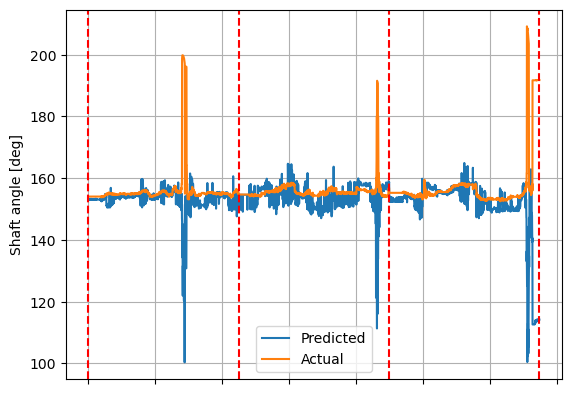

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(shaft_angle_predicted_data, label = "Predicted")
ax.plot(shaft_angle_actual_data, label = "Actual") # -1 = invalid point
for l in lengths: ax.axvline(l, color = "red", linestyle = "dashed")
ax.set_ylabel("Shaft angle [deg]")
ax.set_xticklabels([])
ax.grid()
ax.legend()

print(np.average([actual-pred for actual, pred in zip(shaft_angle_actual_data, shaft_angle_predicted_data)]))
print(np.std([actual-pred for actual, pred in zip(shaft_angle_actual_data, shaft_angle_predicted_data)]))

-5.080619017942025
8.955315857173721


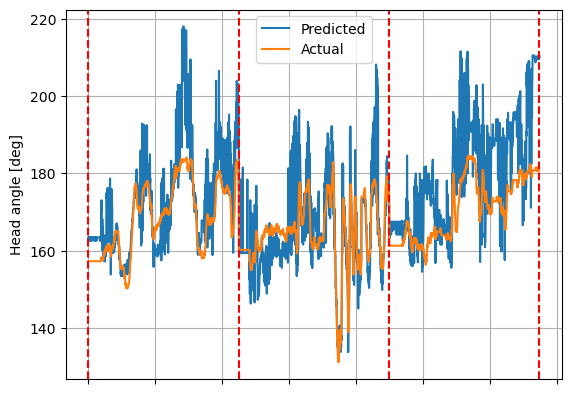

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(head_angle_predicted_data, label = "Predicted")
ax.plot(head_angle_actual_data, label = "Actual")
for l in lengths: ax.axvline(l, color = "red", linestyle = "dashed")
ax.set_ylabel("Head angle [deg]")
ax.set_xticklabels([])
ax.grid()
ax.legend()

print(np.average([actual-pred for actual, pred in zip(head_angle_actual_data, head_angle_predicted_data)]))
print(np.std([actual-pred for actual, pred in zip(head_angle_actual_data, head_angle_predicted_data)]))

3.2458715596330276
12.800973769177116
-2.1831804281345564
6.831284281213046


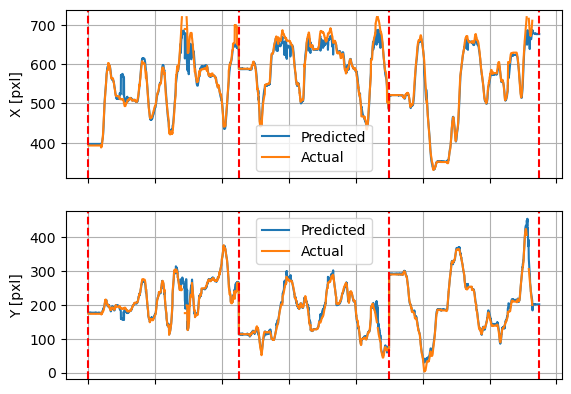

In [16]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, sharex = True)
for i in range(2):
    ax[i].plot([x[i] if x[i] != -1 else np.nan for x in position_predicted_data], label = "Predicted")
    ax[i].plot([x[i] if x[i] != -1 else np.nan for x in position_actual_data], label = "Actual")
    ax[i].set_ylabel("X [pxl]" if i == 0 else "Y [pxl]")
    ax[i].legend()
    for l in lengths: ax[i].axvline(l, color = "red", linestyle = "dashed")
    ax[i].set_xticklabels([])
    ax[i].grid()

print(np.average([actual[0]-pred[0] for actual, pred in zip(position_actual_data, position_predicted_data) if actual[0] != -1 and pred[0] != -1]))
print(np.std([actual[0]-pred[0] for actual, pred in zip(position_actual_data, position_predicted_data) if actual[0] != -1 and pred[0] != -1]))

print(np.average([actual[1]-pred[1] for actual, pred in zip(position_actual_data, position_predicted_data) if actual[1] != -1 and pred[1] != -1]))
print(np.std([actual[1]-pred[1] for actual, pred in zip(position_actual_data, position_predicted_data) if actual[1] != -1 and pred[1] != -1]))